In [1]:
! pip install optuna  scikit-learn gensim imbalanced-learn xgboost torch pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 10.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 9.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report

import numpy as np
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import mean_squared_error
import optuna
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import time
from collections import Counter
# PyTorch Import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import DataParallel


WINDOW_SIZE = 50

# 1 - One Hot Encoding with Pytorch in build Emnedding
# 2 - 3-mer coding with number encoding
ENCODING_METHOD = 2

# 1- Random Over Sampling
# 2 - Weighted Over Sampler
SAMPLING_METHOD =1

# 1 - LSTM with Cross Entropy
MODEL = 1


FRAMEWORK = "PYTORCH"

# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence
# END - Modification is present at End of cropepd Sequence
CROP_STRATEGY = 'MID'

# Y Category Encoding Method
# LABEL or ONE_HOT
TARGET_ENCODING = 'LABEL'

ENCODING_FILE = '3-mer-dictionary.pkl'

In [3]:

# from google.colab import drive
# drive.mount('/content/drive')
# INPUT_TRAIN_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_in.csv"
# INPUT_TRAIN_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_out.csv"
# INPUT_TEST_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_in.csv"
# INPUT_TEST_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_out.csv"
# INPUT_VALIDATION_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_in_nucleo.csv"
# INPUT_VALIDATION_OUT  = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_out.csv"

# Record Constants
# Record Constants
INPUT_TRAIN_IN = "train_in.csv"
INPUT_TRAIN_OUT = "train_out.csv"
INPUT_TEST_IN = "test_in.csv"
INPUT_TEST_OUT = "test_out.csv"
INPUT_VALIDATION_IN = "valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "valid_out.csv"

# TARGET_MODEL_PATH = '../../webapp/model_files'




In [4]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)

print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")


Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


### Calculate Sequence Positions to extracted from Original Sequence

In [5]:
middle_index = (x_train_raw.shape[1] // 2) + 1 # This is location for Modified Sequence . Use this as Y Target

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1
    END_INDEX =middle_index + WINDOW_SIZE

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1
    END_INDEX =middle_index

x_data_cropped =  x_data.iloc[:,STRAT_INEDX :END_INDEX]
concatenated_column= x_data_cropped.apply(lambda row: ''.join(map(str, row)), axis=1)
x_data_cropped = x_data_cropped.assign(Sequence=concatenated_column)

In [6]:
x_data_cropped

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
0,T,T,G,C,C,A,C,A,C,T,...,C,A,G,T,A,T,C,T,C,TTGCCACACTGCTGGACGCCTGCAAGGCCAAGGGTACGGAGGTCAT...
1,T,T,T,G,A,A,A,A,A,A,...,T,C,A,T,C,G,T,G,C,TTTGAAAAAATATTAGCAATGTGAGGACACTTAAGCAGTTTTGTCA...
2,A,G,A,A,A,C,A,T,T,C,...,T,T,C,T,G,T,T,C,A,AGAAACATTCAACCTCCCTTCTTTTTATTCCAGTTGTCCTTTTCTC...
3,T,T,A,G,T,T,T,T,A,C,...,A,A,A,A,A,T,T,T,C,TTAGTTTTACTATGGAATCATAATAACCCACATAGAAGACTGATAT...
4,C,A,A,C,A,G,A,A,G,T,...,A,A,A,A,T,G,T,A,C,CAACAGAAGTTTCTCATCTATAATCAGTAGCACTAAACTCTTGGTT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309455,C,C,A,A,A,C,T,C,T,T,...,G,G,G,C,A,G,A,G,A,CCAAACTCTTTATCTCTTGAGTTCTCAGCCAATAGGGCCATTGTAG...
309456,G,A,T,C,C,A,G,T,T,G,...,A,C,A,G,G,T,A,A,T,GATCCAGTTGAAAACGTATCCCTCTACTTTCTTCAGTTGTAGAAAA...
309457,G,C,C,A,G,G,G,C,A,A,...,C,A,A,G,C,T,G,A,T,GCCAGGGCAAAGCTGGCTGATTTTACGTGTTTAAGGATGAAATATC...
309458,C,T,G,G,G,T,G,C,G,A,...,G,C,A,G,A,G,T,C,A,CTGGGTGCGACAGGCCACTGGACAAGGGCTTGAGTGGATGGGATGG...


In [7]:
x_train_raw = None
y_train_raw = None
x_test_raw = None
y_test_raw = None
x_valid_raw = None
y_valid_raw = None

### Apply One Hot Encoding

In [9]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq))

    return np.array(encoded_sequences).flatten()

def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()

    return tokenized_sequences


### 3 mer coding

In [8]:
import pickle

kmer_dict = {}
k = 3
with open(ENCODING_FILE, 'rb') as f:
    kmer_dict = pickle.load(f)


def encode_with_k_mer_codon(sequence):
    #print(sequence)
    encoded_sequence = []
    for i in range(len(sequence) - k + 1):
        if sequence[i:i+k] not in kmer_dict:
            print("Key Not Found" , kmer_dict)
        encoded_sequence.append(kmer_dict[sequence[i:i+k]] )
    return np.array(encoded_sequence)

In [9]:
## Filter Dataset to Keep only Target Binary Class

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

eligible_class_list = ['hm5C', 'hCm']
ARMEncoding = [0,1]

def convert_y_to_original_labels(row):
    label = ""  
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels



def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.

    y_encoded = []
    for y in y_data:
        index = eligible_class_list.index(y)
        encoding =  ARMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels

    selected_rna_data = x_data[x_data['Label'].isin(prediction_class)]

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered

In [10]:

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data_cropped , y_data , eligible_class_list)


In [11]:
x_data_filtered

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
2782,T,T,T,T,A,A,C,A,C,A,...,T,T,T,T,T,T,T,G,A,TTTTAACACAATACTTTAATAAGACACATTTAAACTCAACTTCTGA...
2783,C,C,T,T,T,G,G,G,G,G,...,A,A,C,A,G,A,T,C,T,CCTTTGGGGGGCTAATAGCTCCTATATTCATTCAAAGAAGGAATAG...
2784,G,G,C,G,C,A,G,G,G,A,...,G,G,A,T,A,T,T,T,A,GGCGCAGGGAAGAGGAAGCGGAGGCACTCGGAAGGTAAGTGGCTAG...
2785,A,A,T,T,A,T,T,T,T,T,...,C,G,A,G,A,C,C,A,T,AATTATTTTTTTAGGGCCGGGCGCGGTGGCTCACGTCTGTAATCCC...
2786,T,G,T,A,T,T,T,T,T,C,...,A,T,T,T,C,T,T,G,C,TGTATTTTTCATGTATGGCCTTTATCATGTTGAGTAAGTTTCTTTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,T,C,T,G,T,T,G,T,C,A,...,G,T,C,T,G,A,T,T,T,TCTGTTGTCATCCTATCATTGACCTGAGATACCAGAGATCGCCAAA...
307507,G,G,A,A,A,G,A,G,A,A,...,T,G,T,G,C,A,G,A,G,GGAAAGAGAACACACACCCCAGGTGTCATGCACACCCTCGGAAGAC...
307508,T,T,T,G,G,A,A,A,A,A,...,A,G,A,G,G,G,C,C,A,TTTGGAAAAAGAGATATCCTAGCTCAGGGCAAGCCGTTTGATGGAA...
307509,T,T,C,A,A,G,C,G,A,T,...,C,A,G,G,G,T,T,T,C,TTCAAGCGATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGATTACA...


In [12]:
y_data_filtered.value_counts()

Label
hm5C    3207
hCm     1878
Name: count, dtype: int64

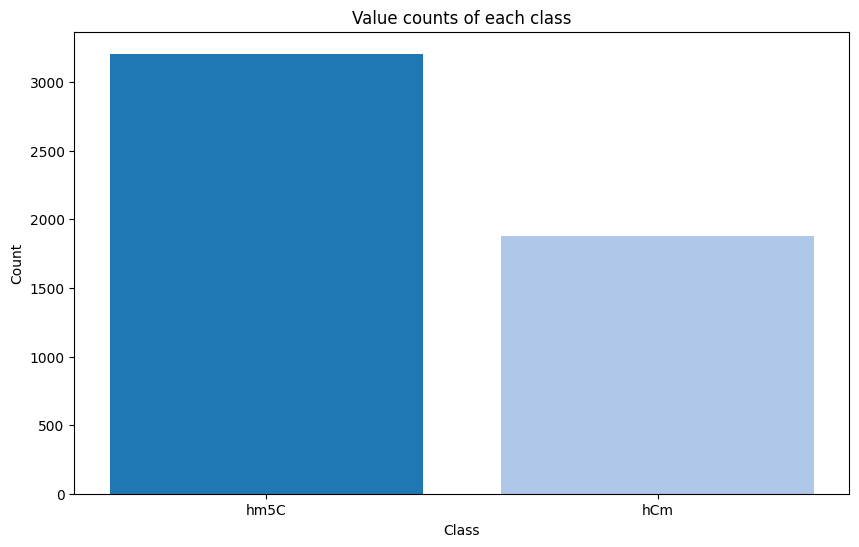

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

y_counts = y_data_filtered.value_counts()
colors = cm.tab20(range(len(y_counts)))
plt.figure(figsize=(10, 6))
plt.bar(y_counts.index, y_counts.values , color = colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Value counts of each class')
plt.show()

In [14]:
x_data_filtered['Sequence']

2782      TTTTAACACAATACTTTAATAAGACACATTTAAACTCAACTTCTGA...
2783      CCTTTGGGGGGCTAATAGCTCCTATATTCATTCAAAGAAGGAATAG...
2784      GGCGCAGGGAAGAGGAAGCGGAGGCACTCGGAAGGTAAGTGGCTAG...
2785      AATTATTTTTTTAGGGCCGGGCGCGGTGGCTCACGTCTGTAATCCC...
2786      TGTATTTTTCATGTATGGCCTTTATCATGTTGAGTAAGTTTCTTTC...
                                ...                        
307506    TCTGTTGTCATCCTATCATTGACCTGAGATACCAGAGATCGCCAAA...
307507    GGAAAGAGAACACACACCCCAGGTGTCATGCACACCCTCGGAAGAC...
307508    TTTGGAAAAAGAGATATCCTAGCTCAGGGCAAGCCGTTTGATGGAA...
307509    TTCAAGCGATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGATTACA...
307510    CTGAGCCCAGCACAGCACCAGAGCTTACCCAAGAATTGCAGTTCTT...
Name: Sequence, Length: 5085, dtype: object

In [15]:
encoded_sequences = [encode_with_k_mer_codon(sequence) for sequence in x_data_filtered['Sequence']]
X_encoded = np.array(encoded_sequences)
X_encoded_tensor = torch.tensor(X_encoded, dtype=torch.float32)
y_encoded = encode_target(y_data_filtered)

In [16]:
X_encoded_tensor

tensor([[50., 50., 62.,  ..., 50., 35., 52.],
        [ 6., 42., 50.,  ..., 55., 12., 22.],
        [17., 44., 30.,  ..., 61., 50., 62.],
        ...,
        [50., 35., 45.,  ..., 17., 29.,  1.],
        [43., 11., 60.,  ..., 34., 50., 43.],
        [25., 52., 39.,  ...,  1.,  2., 33.]])

In [17]:
print("Generate Train and Split..")
# Train set
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Test and Validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Generate Train and Split..


In [18]:
X_encoded = None
y_encoded = None
x_data_filtered , y_data_filtered = None,None
x_data , y_data = None , None

print("Train Y Count : " ,Counter(y_train))
print("Test Y Count : " ,Counter(y_test))


Train Y Count :  Counter({0: 2266, 1: 1293})
Test Y Count :  Counter({0: 457, 1: 306})


### Balance Datset

In [19]:
y_train = torch.tensor(y_train , dtype=torch.long)
y_test = torch.tensor(y_test , dtype=torch.long)
y_valid = torch.tensor(y_valid , dtype=torch.long)

sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled = torch.tensor(y_resampled , dtype=torch.float32) # Keeping float32
X_resampled = torch.tensor(X_resampled , dtype=torch.float32)

In [20]:
print(X_train.shape)
print(y_train.shape)

(3559, 99)
torch.Size([3559])


In [21]:
X_resampled[1]

tensor([54., 61., 43., 22., 42., 62., 32., 12., 13.,  1.,  2., 61., 43., 22.,
        25., 28., 29.,  1.,  2., 61., 43., 22., 25., 28., 18.,  2., 12., 13.,
         6., 42., 50., 62., 47., 48.,  9., 27., 45., 51., 53., 59., 37.,  2.,
        61., 50., 62.,  8., 20., 17., 29.,  1.,  2., 61., 50., 62., 32.,  3.,
        32., 61., 43., 11., 60., 59., 37.,  2., 61., 62.,  8.,  9., 46., 32.,
        61., 35., 52., 53., 63., 63., 48.,  9., 27., 52., 39., 20., 21., 46.,
         4., 58., 14., 22., 42., 43., 22.,  7., 32., 61., 43., 11., 36., 58.,
        25.])

In [61]:
hyperparameter = {}
hyperparameter['INPUT_DIMENSION'] = len(kmer_dict) # For One Hot Encoding Input Dimension would be 4 as there only 4 unique nucleocide
hyperparameter['HIDDEN_DIMENSION'] = 88
hyperparameter['NO_OF_LAYERS'] = 2
hyperparameter['BATCH_SIZE'] = 64
hyperparameter['OUTPUT_DIMENSION'] = len(eligible_class_list)
hyperparameter['EMBEDDING_DIMENSION'] = 16 # if you are using Word2Vec Encoding then this should be same as Word2Vec Embedding Dim
hyperparameter['DROP_OUT'] = 0.18612418176703444
hyperparameter['LEARNING_RATE'] = 0.00010164966155256074

train_losses = []
val_losses = []
val_accuracies = []
    
class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = RNADataset(X_resampled, y_resampled)
test_dataset = RNADataset(X_test, y_test)
valid_dataset = RNADataset(X_valid, y_valid)


train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

In [62]:
import torch.nn as nn

class RNATransformerModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(RNATransformerModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # If batch size first is true then it should be batch size , sequence lenght , embedding dimension
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8, dim_feedforward=hidden_dim , batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        #print("Shape of Original X  ", x.shape)
        x_embedded = self.embedding(x)
        #print("Shape of X embedded" , x_embedded.shape)
        x_transformed = self.transformer_encoder(x_embedded)
        #print("Shape of Transformed X" , x_transformed.shape)
        x_transformed = x_transformed[:, -1, :]  # taking the last token's output

        output = self.dropout(x_transformed)
        out = self.fc(output)
        return out

In [24]:
# Check data is in correct shape - batch size , sequece len , embedding dimension size
for inputs, labels in train_dataloader:
    print(inputs.shape)
    break

torch.Size([512, 99])


In [25]:
import torch.optim.lr_scheduler as lr_scheduler


def validate_model(model, test_dataloader , device ,loss_function):
    model.eval()
    running_loss = 0.0
    class_correct = [0] * hyperparameter['OUTPUT_DIMENSION']
    class_total = [0] * hyperparameter['OUTPUT_DIMENSION']
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())  # Capture True Lables for Summary Report
            predicted_labels.extend(predicted.cpu().numpy()) # Capture Predicted Labels Lables for Summary Report

    validation_loss = running_loss / len(test_dataloader)
    validation_accuracy = correct / total

    return validation_loss , validation_accuracy , true_labels , predicted_labels


def train_model(model, train_dataloader, test_dataloader, device, epochs, optimizer, loss_function):
    best_val_loss = float('inf')
    no_improvement_count = 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 
        
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        val_loss,  validation_accuracy , true_labels , predicted_labels = validate_model(model, test_dataloader, device, loss_function)
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {validation_accuracy:.4f} ,Learning Rate: {optimizer.param_groups[0]['lr']} , Time Taken : {elapsed_time}")
        
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        val_accuracies.append(validation_accuracy)
        
        #scheduler.step()

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             no_improvement_count = 0
#         else:
#             no_improvement_count += 1
#             if no_improvement_count == 20:
#                 print("No improvement in validation loss for 5 epochs. Training stopped.")
#                 break



In [26]:
val_accuracies

[]

In [63]:
model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                            embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                            hidden_dim=hyperparameter['HIDDEN_DIMENSION'] ,
                            num_layers = hyperparameter['NO_OF_LAYERS'],
                            output_dim=hyperparameter['OUTPUT_DIMENSION'],
                            dropout=hyperparameter['DROP_OUT'] )


loss_function = nn.CrossEntropyLoss()  ## MSELoss of Regression problem  # BCELoss for binary classification
optimizer = optim.Adam(model.parameters() ,  lr=hyperparameter['LEARNING_RATE'] , weight_decay=0.000001 )

train_losses = []
val_losses = []
val_accuracies = []

# Number of Parameters for Model
total_parameters = []
for p in model.parameters():
    total_parameters.append(p.numel())

print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

# Train the model
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DataParallel(model)
model = model.to(device)

print("Model Parameters  : " , hyperparameter)

# Train Model with configured Parameter
train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

Total Number of Parameters for Model Training : 13754 
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 88, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.18612418176703444, 'LEARNING_RATE': 0.00010164966155256074}
Epoch 1, Train Loss: 0.7921, Val Loss: 0.7487, Test Accuracy: 0.4875 ,Learning Rate: 0.00010164966155256074 , Time Taken : 3.139392614364624
Epoch 2, Train Loss: 0.7533, Val Loss: 0.7231, Test Accuracy: 0.5033 ,Learning Rate: 0.00010164966155256074 , Time Taken : 3.1806576251983643
Epoch 3, Train Loss: 0.7330, Val Loss: 0.7111, Test Accuracy: 0.5020 ,Learning Rate: 0.00010164966155256074 , Time Taken : 3.1789140701293945
Epoch 4, Train Loss: 0.7264, Val Loss: 0.7071, Test Accuracy: 0.4967 ,Learning Rate: 0.00010164966155256074 , Time Taken : 3.1842455863952637
Epoch 5, Train Loss: 0.7177, Val Loss: 0.7020, Test Accuracy: 0.5125 ,Learning Rate: 0.00010164966155256074 , Time Taken : 3.0526366233825684
Epoch 

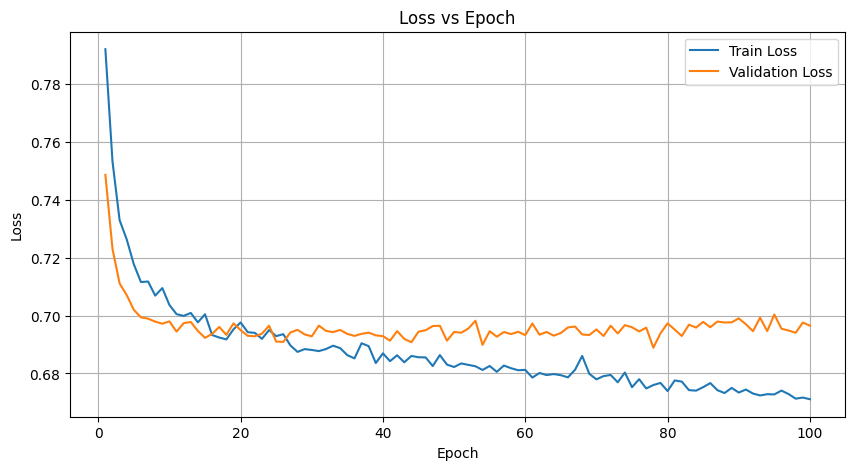

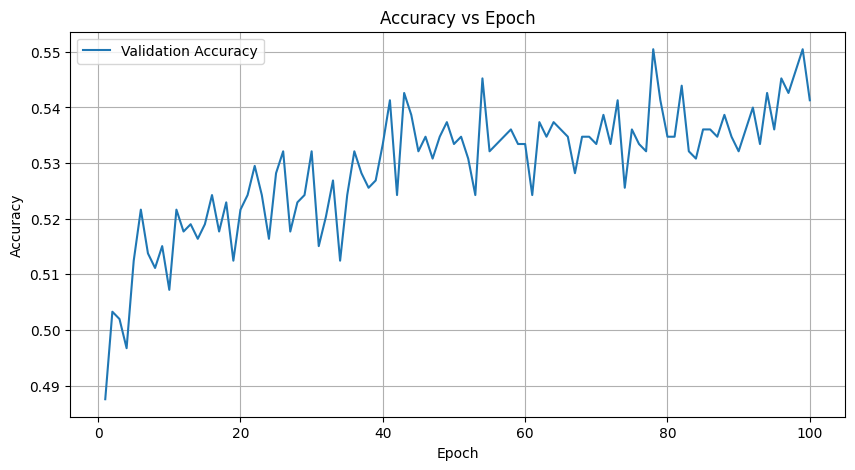

In [65]:
import matplotlib.pyplot as plt


# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


### Optuna Hyperparameter Optimization

In [60]:
import optuna

def objective(trial):
    hyperparameter = {}
    hyperparameter['INPUT_DIMENSION'] = len(kmer_dict)
    hyperparameter['HIDDEN_DIMENSION'] = trial.suggest_int('HIDDEN_DIMENSION', 16, 128)
    hyperparameter['NO_OF_LAYERS'] = trial.suggest_int('NO_OF_LAYERS', 1, 4)
    hyperparameter['BATCH_SIZE'] = trial.suggest_categorical('BATCH_SIZE', [64, 512, 1024])
    hyperparameter['OUTPUT_DIMENSION'] = len(eligible_class_list)
    hyperparameter['EMBEDDING_DIMENSION'] = 16  # Adjust as needed
    hyperparameter['DROP_OUT'] = trial.suggest_float('DROP_OUT', 0.1, 0.5)
    hyperparameter['LEARNING_RATE'] = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-3)

    model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                                embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                                hidden_dim=hyperparameter['HIDDEN_DIMENSION'],
                                num_layers=hyperparameter['NO_OF_LAYERS'],
                                output_dim=hyperparameter['OUTPUT_DIMENSION'],
                                dropout=hyperparameter['DROP_OUT'])

    model = DataParallel(model)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameter['LEARNING_RATE'])

    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

    num_epochs = 50
    print("Model Parameters  : " , hyperparameter)
    
    train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

    _, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

    return final_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

    # Print the result
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-14 06:42:35,983] A new study created in memory with name: no-name-4719fd28-6866-4833-9587-b59e0664d408
/tmp/ipykernel_682/3044487090.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  hyperparameter['LEARNING_RATE'] = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-3)


Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 127, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.3218775692645613, 'LEARNING_RATE': 2.617623336579906e-05}
Epoch 1, Train Loss: 0.7677, Val Loss: 0.7541, Test Accuracy: 0.4718 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.584235429763794
Epoch 2, Train Loss: 0.7679, Val Loss: 0.7498, Test Accuracy: 0.4744 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.5493006706237793
Epoch 3, Train Loss: 0.7685, Val Loss: 0.7457, Test Accuracy: 0.4731 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.5541126728057861
Epoch 4, Train Loss: 0.7560, Val Loss: 0.7420, Test Accuracy: 0.4771 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.5458157062530518
Epoch 5, Train Loss: 0.7530, Val Loss: 0.7387, Test Accuracy: 0.4784 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.5549993515014648
Epoch 6, Train Loss: 0.7593, Val Loss: 0.7358, Test Accuracy: 0.48

[I 2023-08-14 06:43:04,027] Trial 0 finished with value: 0.44692005242463956 and parameters: {'HIDDEN_DIMENSION': 127, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'DROP_OUT': 0.3218775692645613, 'LEARNING_RATE': 2.617623336579906e-05}. Best is trial 0 with value: 0.44692005242463956.


Epoch 50, Train Loss: 0.7268, Val Loss: 0.7040, Test Accuracy: 0.4849 ,Learning Rate: 2.617623336579906e-05 , Time Taken : 0.548882007598877
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 103, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.12366135111140807, 'LEARNING_RATE': 4.444213029341879e-05}
Epoch 1, Train Loss: 0.8183, Val Loss: 0.8066, Test Accuracy: 0.4889 ,Learning Rate: 4.444213029341879e-05 , Time Taken : 0.2939455509185791
Epoch 2, Train Loss: 0.8095, Val Loss: 0.8050, Test Accuracy: 0.4889 ,Learning Rate: 4.444213029341879e-05 , Time Taken : 0.2932891845703125
Epoch 3, Train Loss: 0.8131, Val Loss: 0.8035, Test Accuracy: 0.4889 ,Learning Rate: 4.444213029341879e-05 , Time Taken : 0.2927114963531494
Epoch 4, Train Loss: 0.8091, Val Loss: 0.8020, Test Accuracy: 0.4875 ,Learning Rate: 4.444213029341879e-05 , Time Taken : 0.2929387092590332
Epoch 5, Train Loss: 0.8097, Val Loss: 0.8004, Test Accuracy: 0

[I 2023-08-14 06:43:19,152] Trial 1 finished with value: 0.4927916120576671 and parameters: {'HIDDEN_DIMENSION': 103, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.12366135111140807, 'LEARNING_RATE': 4.444213029341879e-05}. Best is trial 1 with value: 0.4927916120576671.


Epoch 50, Train Loss: 0.7464, Val Loss: 0.7427, Test Accuracy: 0.4771 ,Learning Rate: 4.444213029341879e-05 , Time Taken : 0.4925954341888428
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.15838352362616967, 'LEARNING_RATE': 0.000891156666297818}
Epoch 1, Train Loss: 0.7267, Val Loss: 0.7032, Test Accuracy: 0.4902 ,Learning Rate: 0.000891156666297818 , Time Taken : 1.028637409210205
Epoch 2, Train Loss: 0.7023, Val Loss: 0.6909, Test Accuracy: 0.5360 ,Learning Rate: 0.000891156666297818 , Time Taken : 1.0305655002593994
Epoch 3, Train Loss: 0.6937, Val Loss: 0.6999, Test Accuracy: 0.4705 ,Learning Rate: 0.000891156666297818 , Time Taken : 1.0311877727508545
Epoch 4, Train Loss: 0.6941, Val Loss: 0.6920, Test Accuracy: 0.5203 ,Learning Rate: 0.000891156666297818 , Time Taken : 1.0274291038513184
Epoch 5, Train Loss: 0.6941, Val Loss: 0.6931, Test Accuracy: 0.5177 ,

[I 2023-08-14 06:44:10,810] Trial 2 finished with value: 0.5216251638269986 and parameters: {'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.15838352362616967, 'LEARNING_RATE': 0.000891156666297818}. Best is trial 2 with value: 0.5216251638269986.


Epoch 50, Train Loss: 0.6336, Val Loss: 0.7495, Test Accuracy: 0.5177 ,Learning Rate: 0.000891156666297818 , Time Taken : 1.037951946258545
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 125, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.22447643284566254, 'LEARNING_RATE': 0.00012585476001500062}
Epoch 1, Train Loss: 0.7868, Val Loss: 0.7278, Test Accuracy: 0.4889 ,Learning Rate: 0.00012585476001500062 , Time Taken : 0.5535504817962646
Epoch 2, Train Loss: 0.7550, Val Loss: 0.7223, Test Accuracy: 0.4731 ,Learning Rate: 0.00012585476001500062 , Time Taken : 0.5498790740966797
Epoch 3, Train Loss: 0.7381, Val Loss: 0.7160, Test Accuracy: 0.4771 ,Learning Rate: 0.00012585476001500062 , Time Taken : 0.5508663654327393
Epoch 4, Train Loss: 0.7268, Val Loss: 0.7114, Test Accuracy: 0.4731 ,Learning Rate: 0.00012585476001500062 , Time Taken : 0.5481016635894775
Epoch 5, Train Loss: 0.7146, Val Loss: 0.7075, Test Accuracy:

[I 2023-08-14 06:44:37,996] Trial 3 finished with value: 0.5583224115334207 and parameters: {'HIDDEN_DIMENSION': 125, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'DROP_OUT': 0.22447643284566254, 'LEARNING_RATE': 0.00012585476001500062}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.6805, Val Loss: 0.6957, Test Accuracy: 0.5072 ,Learning Rate: 0.00012585476001500062 , Time Taken : 0.5475625991821289
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 18, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.2330000996911964, 'LEARNING_RATE': 0.0005302628927086526}
Epoch 1, Train Loss: 0.8274, Val Loss: 0.7708, Test Accuracy: 0.4928 ,Learning Rate: 0.0005302628927086526 , Time Taken : 0.5281846523284912
Epoch 2, Train Loss: 0.7640, Val Loss: 0.7300, Test Accuracy: 0.4993 ,Learning Rate: 0.0005302628927086526 , Time Taken : 0.5351672172546387
Epoch 3, Train Loss: 0.7280, Val Loss: 0.7170, Test Accuracy: 0.4928 ,Learning Rate: 0.0005302628927086526 , Time Taken : 0.5357661247253418
Epoch 4, Train Loss: 0.7158, Val Loss: 0.7074, Test Accuracy: 0.4967 ,Learning Rate: 0.0005302628927086526 , Time Taken : 0.5393600463867188
Epoch 5, Train Loss: 0.7068, Val Loss: 0.7008, Test Accuracy: 0.5

[I 2023-08-14 06:45:04,776] Trial 4 finished with value: 0.5058977719528178 and parameters: {'HIDDEN_DIMENSION': 18, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'DROP_OUT': 0.2330000996911964, 'LEARNING_RATE': 0.0005302628927086526}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.6480, Val Loss: 0.7300, Test Accuracy: 0.5164 ,Learning Rate: 0.0005302628927086526 , Time Taken : 0.5379881858825684
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 66, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.20906997535552097, 'LEARNING_RATE': 0.00019294355287868416}
Epoch 1, Train Loss: 0.7832, Val Loss: 0.7882, Test Accuracy: 0.4430 ,Learning Rate: 0.00019294355287868416 , Time Taken : 0.7127399444580078
Epoch 2, Train Loss: 0.7672, Val Loss: 0.7737, Test Accuracy: 0.4522 ,Learning Rate: 0.00019294355287868416 , Time Taken : 0.5340754985809326
Epoch 3, Train Loss: 0.7646, Val Loss: 0.7615, Test Accuracy: 0.4587 ,Learning Rate: 0.00019294355287868416 , Time Taken : 0.5384979248046875
Epoch 4, Train Loss: 0.7556, Val Loss: 0.7514, Test Accuracy: 0.4771 ,Learning Rate: 0.00019294355287868416 , Time Taken : 0.5352022647857666
Epoch 5, Train Loss: 0.7536, Val Loss: 0.7431, Test Accura

[I 2023-08-14 06:45:32,149] Trial 5 finished with value: 0.5137614678899083 and parameters: {'HIDDEN_DIMENSION': 66, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.20906997535552097, 'LEARNING_RATE': 0.00019294355287868416}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.6950, Val Loss: 0.6929, Test Accuracy: 0.5374 ,Learning Rate: 0.00019294355287868416 , Time Taken : 0.5360779762268066
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 110, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.4519083011343309, 'LEARNING_RATE': 6.898956767288799e-05}
Epoch 1, Train Loss: 0.7881, Val Loss: 0.6898, Test Accuracy: 0.5767 ,Learning Rate: 6.898956767288799e-05 , Time Taken : 1.039959192276001
Epoch 2, Train Loss: 0.7823, Val Loss: 0.6905, Test Accuracy: 0.5754 ,Learning Rate: 6.898956767288799e-05 , Time Taken : 1.0421810150146484
Epoch 3, Train Loss: 0.7669, Val Loss: 0.6913, Test Accuracy: 0.5714 ,Learning Rate: 6.898956767288799e-05 , Time Taken : 1.0432109832763672
Epoch 4, Train Loss: 0.7637, Val Loss: 0.6921, Test Accuracy: 0.5623 ,Learning Rate: 6.898956767288799e-05 , Time Taken : 1.0404856204986572
Epoch 5, Train Loss: 0.7649, Val Loss: 0.6922, Test Accuracy: 0

[I 2023-08-14 06:46:24,855] Trial 6 finished with value: 0.49148099606815204 and parameters: {'HIDDEN_DIMENSION': 110, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.4519083011343309, 'LEARNING_RATE': 6.898956767288799e-05}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.7032, Val Loss: 0.6897, Test Accuracy: 0.5269 ,Learning Rate: 6.898956767288799e-05 , Time Taken : 1.0469744205474854
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 52, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.23152006931951072, 'LEARNING_RATE': 8.399480149738918e-05}
Epoch 1, Train Loss: 0.7843, Val Loss: 0.7654, Test Accuracy: 0.5151 ,Learning Rate: 8.399480149738918e-05 , Time Taken : 0.7709457874298096
Epoch 2, Train Loss: 0.7822, Val Loss: 0.7623, Test Accuracy: 0.5098 ,Learning Rate: 8.399480149738918e-05 , Time Taken : 0.7755084037780762
Epoch 3, Train Loss: 0.7868, Val Loss: 0.7600, Test Accuracy: 0.5111 ,Learning Rate: 8.399480149738918e-05 , Time Taken : 0.7753057479858398
Epoch 4, Train Loss: 0.7713, Val Loss: 0.7572, Test Accuracy: 0.5085 ,Learning Rate: 8.399480149738918e-05 , Time Taken : 0.7716095447540283
Epoch 5, Train Loss: 0.7680, Val Loss: 0.7547, Test Accuracy: 0

[I 2023-08-14 06:47:04,047] Trial 7 finished with value: 0.5058977719528178 and parameters: {'HIDDEN_DIMENSION': 52, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.23152006931951072, 'LEARNING_RATE': 8.399480149738918e-05}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.7098, Val Loss: 0.7030, Test Accuracy: 0.5007 ,Learning Rate: 8.399480149738918e-05 , Time Taken : 0.7734057903289795
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 114, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.13977059386791366, 'LEARNING_RATE': 0.00010920926664585334}
Epoch 1, Train Loss: 0.7345, Val Loss: 0.7146, Test Accuracy: 0.4967 ,Learning Rate: 0.00010920926664585334 , Time Taken : 1.0656218528747559
Epoch 2, Train Loss: 0.7211, Val Loss: 0.7183, Test Accuracy: 0.4705 ,Learning Rate: 0.00010920926664585334 , Time Taken : 1.0690562725067139
Epoch 3, Train Loss: 0.7166, Val Loss: 0.7173, Test Accuracy: 0.4705 ,Learning Rate: 0.00010920926664585334 , Time Taken : 1.0668683052062988
Epoch 4, Train Loss: 0.7126, Val Loss: 0.7090, Test Accuracy: 0.4744 ,Learning Rate: 0.00010920926664585334 , Time Taken : 1.0635066032409668
Epoch 5, Train Loss: 0.7096, Val Loss: 0.7047, Test Accura

[I 2023-08-14 06:47:57,717] Trial 8 finished with value: 0.5570117955439057 and parameters: {'HIDDEN_DIMENSION': 114, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.13977059386791366, 'LEARNING_RATE': 0.00010920926664585334}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.6891, Val Loss: 0.6897, Test Accuracy: 0.5387 ,Learning Rate: 0.00010920926664585334 , Time Taken : 1.0748093128204346
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 73, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.4897903535307605, 'LEARNING_RATE': 0.00025519086999254597}
Epoch 1, Train Loss: 0.9605, Val Loss: 0.7870, Test Accuracy: 0.5177 ,Learning Rate: 0.00025519086999254597 , Time Taken : 0.5433971881866455
Epoch 2, Train Loss: 0.9334, Val Loss: 0.7758, Test Accuracy: 0.5138 ,Learning Rate: 0.00025519086999254597 , Time Taken : 0.5422558784484863
Epoch 3, Train Loss: 0.9310, Val Loss: 0.7654, Test Accuracy: 0.5151 ,Learning Rate: 0.00025519086999254597 , Time Taken : 0.5435795783996582
Epoch 4, Train Loss: 0.8945, Val Loss: 0.7550, Test Accuracy: 0.5151 ,Learning Rate: 0.00025519086999254597 , Time Taken : 0.5405950546264648
Epoch 5, Train Loss: 0.8775, Val Loss: 0.7476, Test Accura

[I 2023-08-14 06:48:25,135] Trial 9 finished with value: 0.4941022280471822 and parameters: {'HIDDEN_DIMENSION': 73, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.4897903535307605, 'LEARNING_RATE': 0.00025519086999254597}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.7105, Val Loss: 0.6924, Test Accuracy: 0.5098 ,Learning Rate: 0.00025519086999254597 , Time Taken : 0.5486302375793457
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 30, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.3282299474281164, 'LEARNING_RATE': 1.2252191924359754e-05}
Epoch 1, Train Loss: 0.7960, Val Loss: 0.7675, Test Accuracy: 0.4823 ,Learning Rate: 1.2252191924359754e-05 , Time Taken : 0.537384033203125
Epoch 2, Train Loss: 0.8040, Val Loss: 0.7658, Test Accuracy: 0.4823 ,Learning Rate: 1.2252191924359754e-05 , Time Taken : 0.5470952987670898
Epoch 3, Train Loss: 0.7960, Val Loss: 0.7641, Test Accuracy: 0.4836 ,Learning Rate: 1.2252191924359754e-05 , Time Taken : 0.5502488613128662
Epoch 4, Train Loss: 0.8014, Val Loss: 0.7624, Test Accuracy: 0.4823 ,Learning Rate: 1.2252191924359754e-05 , Time Taken : 0.5510714054107666
Epoch 5, Train Loss: 0.7924, Val Loss: 0.7609, Test Accuracy:

[I 2023-08-14 06:48:52,640] Trial 10 finished with value: 0.47182175622542594 and parameters: {'HIDDEN_DIMENSION': 30, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 64, 'DROP_OUT': 0.3282299474281164, 'LEARNING_RATE': 1.2252191924359754e-05}. Best is trial 3 with value: 0.5583224115334207.


Epoch 50, Train Loss: 0.7406, Val Loss: 0.7188, Test Accuracy: 0.4744 ,Learning Rate: 1.2252191924359754e-05 , Time Taken : 0.5467631816864014
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 126, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.12993644704680013, 'LEARNING_RATE': 0.00015607305727562257}
Epoch 1, Train Loss: 0.7708, Val Loss: 0.7445, Test Accuracy: 0.4849 ,Learning Rate: 0.00015607305727562257 , Time Taken : 0.8176407814025879
Epoch 2, Train Loss: 0.7453, Val Loss: 0.7337, Test Accuracy: 0.4875 ,Learning Rate: 0.00015607305727562257 , Time Taken : 0.8199117183685303
Epoch 3, Train Loss: 0.7278, Val Loss: 0.7198, Test Accuracy: 0.4954 ,Learning Rate: 0.00015607305727562257 , Time Taken : 0.8263728618621826
Epoch 4, Train Loss: 0.7195, Val Loss: 0.7106, Test Accuracy: 0.5098 ,Learning Rate: 0.00015607305727562257 , Time Taken : 1.0050437450408936
Epoch 5, Train Loss: 0.7132, Val Loss: 0.7039, Test Accur

[I 2023-08-14 06:49:34,190] Trial 11 finished with value: 0.5674967234600262 and parameters: {'HIDDEN_DIMENSION': 126, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'DROP_OUT': 0.12993644704680013, 'LEARNING_RATE': 0.00015607305727562257}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6871, Val Loss: 0.6954, Test Accuracy: 0.5518 ,Learning Rate: 0.00015607305727562257 , Time Taken : 0.8163998126983643
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 127, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.10270723107018082, 'LEARNING_RATE': 0.00018388492519697043}
Epoch 1, Train Loss: 0.7387, Val Loss: 0.7065, Test Accuracy: 0.5033 ,Learning Rate: 0.00018388492519697043 , Time Taken : 1.1640963554382324
Epoch 2, Train Loss: 0.6987, Val Loss: 0.7071, Test Accuracy: 0.4705 ,Learning Rate: 0.00018388492519697043 , Time Taken : 1.1728851795196533
Epoch 3, Train Loss: 0.6943, Val Loss: 0.6924, Test Accuracy: 0.5295 ,Learning Rate: 0.00018388492519697043 , Time Taken : 1.1660053730010986
Epoch 4, Train Loss: 0.6919, Val Loss: 0.6947, Test Accuracy: 0.5020 ,Learning Rate: 0.00018388492519697043 , Time Taken : 1.1681716442108154
Epoch 5, Train Loss: 0.6904, Val Loss: 0.6846, Test Accura

[I 2023-08-14 06:50:32,604] Trial 12 finished with value: 0.5334207077326344 and parameters: {'HIDDEN_DIMENSION': 127, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.10270723107018082, 'LEARNING_RATE': 0.00018388492519697043}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6601, Val Loss: 0.7122, Test Accuracy: 0.5059 ,Learning Rate: 0.00018388492519697043 , Time Taken : 1.1638505458831787
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 94, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1907576697119489, 'LEARNING_RATE': 0.0003357891389023947}
Epoch 1, Train Loss: 0.7303, Val Loss: 0.6928, Test Accuracy: 0.5151 ,Learning Rate: 0.0003357891389023947 , Time Taken : 1.1710851192474365
Epoch 2, Train Loss: 0.7060, Val Loss: 0.7013, Test Accuracy: 0.4758 ,Learning Rate: 0.0003357891389023947 , Time Taken : 1.159956455230713
Epoch 3, Train Loss: 0.6996, Val Loss: 0.6919, Test Accuracy: 0.5085 ,Learning Rate: 0.0003357891389023947 , Time Taken : 1.1569581031799316
Epoch 4, Train Loss: 0.6955, Val Loss: 0.6995, Test Accuracy: 0.4456 ,Learning Rate: 0.0003357891389023947 , Time Taken : 1.158125638961792
Epoch 5, Train Loss: 0.6953, Val Loss: 0.6944, Test Accuracy: 0.477

[I 2023-08-14 06:51:30,159] Trial 13 finished with value: 0.5163826998689384 and parameters: {'HIDDEN_DIMENSION': 94, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.1907576697119489, 'LEARNING_RATE': 0.0003357891389023947}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6454, Val Loss: 0.7453, Test Accuracy: 0.4862 ,Learning Rate: 0.0003357891389023947 , Time Taken : 1.1585807800292969
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 128, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.27951486974643647, 'LEARNING_RATE': 0.00011652784973727726}
Epoch 1, Train Loss: 0.8053, Val Loss: 0.7993, Test Accuracy: 0.4692 ,Learning Rate: 0.00011652784973727726 , Time Taken : 0.5717718601226807
Epoch 2, Train Loss: 0.7917, Val Loss: 0.7846, Test Accuracy: 0.4810 ,Learning Rate: 0.00011652784973727726 , Time Taken : 0.568718433380127
Epoch 3, Train Loss: 0.7755, Val Loss: 0.7739, Test Accuracy: 0.4771 ,Learning Rate: 0.00011652784973727726 , Time Taken : 0.5692486763000488
Epoch 4, Train Loss: 0.7748, Val Loss: 0.7633, Test Accuracy: 0.4784 ,Learning Rate: 0.00011652784973727726 , Time Taken : 0.5668239593505859
Epoch 5, Train Loss: 0.7619, Val Loss: 0.7541, Test Accurac

[I 2023-08-14 06:51:58,812] Trial 14 finished with value: 0.5242463958060288 and parameters: {'HIDDEN_DIMENSION': 128, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 512, 'DROP_OUT': 0.27951486974643647, 'LEARNING_RATE': 0.00011652784973727726}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6949, Val Loss: 0.6937, Test Accuracy: 0.5111 ,Learning Rate: 0.00011652784973727726 , Time Taken : 0.5695233345031738
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 84, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.17177405294612696, 'LEARNING_RATE': 0.0001440564379446349}
Epoch 1, Train Loss: 0.7560, Val Loss: 0.7214, Test Accuracy: 0.4902 ,Learning Rate: 0.0001440564379446349 , Time Taken : 1.1497833728790283
Epoch 2, Train Loss: 0.7289, Val Loss: 0.7144, Test Accuracy: 0.4862 ,Learning Rate: 0.0001440564379446349 , Time Taken : 1.160628318786621
Epoch 3, Train Loss: 0.7134, Val Loss: 0.7023, Test Accuracy: 0.5033 ,Learning Rate: 0.0001440564379446349 , Time Taken : 1.1543078422546387
Epoch 4, Train Loss: 0.7079, Val Loss: 0.7038, Test Accuracy: 0.4980 ,Learning Rate: 0.0001440564379446349 , Time Taken : 1.164010763168335
Epoch 5, Train Loss: 0.7028, Val Loss: 0.6979, Test Accuracy: 0.49

[I 2023-08-14 06:52:56,398] Trial 15 finished with value: 0.54521625163827 and parameters: {'HIDDEN_DIMENSION': 84, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.17177405294612696, 'LEARNING_RATE': 0.0001440564379446349}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6756, Val Loss: 0.7010, Test Accuracy: 0.5151 ,Learning Rate: 0.0001440564379446349 , Time Taken : 1.1690292358398438
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 111, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.10126890396003116, 'LEARNING_RATE': 0.00034304297363360424}
Epoch 1, Train Loss: 0.8152, Val Loss: 0.7684, Test Accuracy: 0.4993 ,Learning Rate: 0.00034304297363360424 , Time Taken : 0.3215982913970947
Epoch 2, Train Loss: 0.7929, Val Loss: 0.7492, Test Accuracy: 0.5020 ,Learning Rate: 0.00034304297363360424 , Time Taken : 0.32335996627807617
Epoch 3, Train Loss: 0.7767, Val Loss: 0.7353, Test Accuracy: 0.5007 ,Learning Rate: 0.00034304297363360424 , Time Taken : 0.3223097324371338
Epoch 4, Train Loss: 0.7573, Val Loss: 0.7228, Test Accuracy: 0.5059 ,Learning Rate: 0.00034304297363360424 , Time Taken : 0.3184351921081543
Epoch 5, Train Loss: 0.7422, Val Loss: 0.7130, Test Accur

[I 2023-08-14 06:53:12,501] Trial 16 finished with value: 0.5321100917431193 and parameters: {'HIDDEN_DIMENSION': 111, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'DROP_OUT': 0.10126890396003116, 'LEARNING_RATE': 0.00034304297363360424}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6820, Val Loss: 0.6970, Test Accuracy: 0.5439 ,Learning Rate: 0.00034304297363360424 , Time Taken : 0.31876158714294434
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 53, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1595485180427248, 'LEARNING_RATE': 6.422468611793918e-05}
Epoch 1, Train Loss: 0.8002, Val Loss: 0.7347, Test Accuracy: 0.5321 ,Learning Rate: 6.422468611793918e-05 , Time Taken : 0.8460516929626465
Epoch 2, Train Loss: 0.7562, Val Loss: 0.7331, Test Accuracy: 0.5321 ,Learning Rate: 6.422468611793918e-05 , Time Taken : 0.8533892631530762
Epoch 3, Train Loss: 0.7487, Val Loss: 0.7311, Test Accuracy: 0.5321 ,Learning Rate: 6.422468611793918e-05 , Time Taken : 0.8585250377655029
Epoch 4, Train Loss: 0.7391, Val Loss: 0.7283, Test Accuracy: 0.5269 ,Learning Rate: 6.422468611793918e-05 , Time Taken : 0.8503086566925049
Epoch 5, Train Loss: 0.7341, Val Loss: 0.7246, Test Accuracy: 0.

[I 2023-08-14 06:53:54,361] Trial 17 finished with value: 0.5203145478374837 and parameters: {'HIDDEN_DIMENSION': 53, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.1595485180427248, 'LEARNING_RATE': 6.422468611793918e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6863, Val Loss: 0.6989, Test Accuracy: 0.5138 ,Learning Rate: 6.422468611793918e-05 , Time Taken : 0.8549096584320068
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 97, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.26674470298068387, 'LEARNING_RATE': 0.00019621816446518896}
Epoch 1, Train Loss: 0.7427, Val Loss: 0.7180, Test Accuracy: 0.5125 ,Learning Rate: 0.00019621816446518896 , Time Taken : 0.8333590030670166
Epoch 2, Train Loss: 0.7311, Val Loss: 0.7112, Test Accuracy: 0.5334 ,Learning Rate: 0.00019621816446518896 , Time Taken : 0.8209366798400879
Epoch 3, Train Loss: 0.7173, Val Loss: 0.7086, Test Accuracy: 0.5321 ,Learning Rate: 0.00019621816446518896 , Time Taken : 0.8222494125366211
Epoch 4, Train Loss: 0.7133, Val Loss: 0.7048, Test Accuracy: 0.5229 ,Learning Rate: 0.00019621816446518896 , Time Taken : 0.8270761966705322
Epoch 5, Train Loss: 0.7095, Val Loss: 0.7025, Test Accurac

[I 2023-08-14 06:54:35,636] Trial 18 finished with value: 0.5190039318479686 and parameters: {'HIDDEN_DIMENSION': 97, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'DROP_OUT': 0.26674470298068387, 'LEARNING_RATE': 0.00019621816446518896}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6863, Val Loss: 0.6943, Test Accuracy: 0.5242 ,Learning Rate: 0.00019621816446518896 , Time Taken : 0.8176124095916748
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 116, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.19899538547221363, 'LEARNING_RATE': 0.00012267467804654016}
Epoch 1, Train Loss: 0.7507, Val Loss: 0.7243, Test Accuracy: 0.5033 ,Learning Rate: 0.00012267467804654016 , Time Taken : 1.4843087196350098
Epoch 2, Train Loss: 0.7145, Val Loss: 0.7073, Test Accuracy: 0.5098 ,Learning Rate: 0.00012267467804654016 , Time Taken : 1.4872591495513916
Epoch 3, Train Loss: 0.7068, Val Loss: 0.6993, Test Accuracy: 0.5190 ,Learning Rate: 0.00012267467804654016 , Time Taken : 1.4967305660247803
Epoch 4, Train Loss: 0.7014, Val Loss: 0.6970, Test Accuracy: 0.5138 ,Learning Rate: 0.00012267467804654016 , Time Taken : 1.4973196983337402
Epoch 5, Train Loss: 0.6974, Val Loss: 0.6972, Test Accura

[I 2023-08-14 06:55:50,647] Trial 19 finished with value: 0.4849279161205767 and parameters: {'HIDDEN_DIMENSION': 116, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 64, 'DROP_OUT': 0.19899538547221363, 'LEARNING_RATE': 0.00012267467804654016}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6663, Val Loss: 0.7100, Test Accuracy: 0.4862 ,Learning Rate: 0.00012267467804654016 , Time Taken : 1.4959123134613037
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 76, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.13256233556556257, 'LEARNING_RATE': 4.925292978290732e-05}
Epoch 1, Train Loss: 0.7415, Val Loss: 0.7545, Test Accuracy: 0.4915 ,Learning Rate: 4.925292978290732e-05 , Time Taken : 0.3197004795074463
Epoch 2, Train Loss: 0.7393, Val Loss: 0.7538, Test Accuracy: 0.4993 ,Learning Rate: 4.925292978290732e-05 , Time Taken : 0.3239414691925049
Epoch 3, Train Loss: 0.7372, Val Loss: 0.7531, Test Accuracy: 0.5046 ,Learning Rate: 4.925292978290732e-05 , Time Taken : 0.31553125381469727
Epoch 4, Train Loss: 0.7387, Val Loss: 0.7524, Test Accuracy: 0.5033 ,Learning Rate: 4.925292978290732e-05 , Time Taken : 0.31450724601745605
Epoch 5, Train Loss: 0.7354, Val Loss: 0.7517, Test Accuracy:

[I 2023-08-14 06:56:06,800] Trial 20 finished with value: 0.4941022280471822 and parameters: {'HIDDEN_DIMENSION': 76, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'DROP_OUT': 0.13256233556556257, 'LEARNING_RATE': 4.925292978290732e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.7075, Val Loss: 0.7233, Test Accuracy: 0.4915 ,Learning Rate: 4.925292978290732e-05 , Time Taken : 0.31944870948791504
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 117, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1461258860426837, 'LEARNING_RATE': 0.0001009834801905927}
Epoch 1, Train Loss: 0.7686, Val Loss: 0.7120, Test Accuracy: 0.5203 ,Learning Rate: 0.0001009834801905927 , Time Taken : 1.0725491046905518
Epoch 2, Train Loss: 0.7372, Val Loss: 0.7201, Test Accuracy: 0.4771 ,Learning Rate: 0.0001009834801905927 , Time Taken : 1.0819146633148193
Epoch 3, Train Loss: 0.7277, Val Loss: 0.7288, Test Accuracy: 0.4666 ,Learning Rate: 0.0001009834801905927 , Time Taken : 1.0800514221191406
Epoch 4, Train Loss: 0.7235, Val Loss: 0.7268, Test Accuracy: 0.4653 ,Learning Rate: 0.0001009834801905927 , Time Taken : 1.0846431255340576
Epoch 5, Train Loss: 0.7179, Val Loss: 0.7205, Test Accuracy: 0

[I 2023-08-14 06:57:01,344] Trial 21 finished with value: 0.526867627785059 and parameters: {'HIDDEN_DIMENSION': 117, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.1461258860426837, 'LEARNING_RATE': 0.0001009834801905927}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6888, Val Loss: 0.6966, Test Accuracy: 0.5151 ,Learning Rate: 0.0001009834801905927 , Time Taken : 1.0884308815002441
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 119, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1344994111933855, 'LEARNING_RATE': 0.00013354964626653443}
Epoch 1, Train Loss: 0.7810, Val Loss: 0.7100, Test Accuracy: 0.5452 ,Learning Rate: 0.00013354964626653443 , Time Taken : 1.0850398540496826
Epoch 2, Train Loss: 0.7447, Val Loss: 0.7134, Test Accuracy: 0.4915 ,Learning Rate: 0.00013354964626653443 , Time Taken : 1.088913917541504
Epoch 3, Train Loss: 0.7271, Val Loss: 0.7206, Test Accuracy: 0.4522 ,Learning Rate: 0.00013354964626653443 , Time Taken : 1.0895540714263916
Epoch 4, Train Loss: 0.7206, Val Loss: 0.7190, Test Accuracy: 0.4469 ,Learning Rate: 0.00013354964626653443 , Time Taken : 1.0884215831756592
Epoch 5, Train Loss: 0.7123, Val Loss: 0.7103, Test Accuracy

[I 2023-08-14 06:57:56,103] Trial 22 finished with value: 0.5032765399737876 and parameters: {'HIDDEN_DIMENSION': 119, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.1344994111933855, 'LEARNING_RATE': 0.00013354964626653443}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6894, Val Loss: 0.6975, Test Accuracy: 0.4875 ,Learning Rate: 0.00013354964626653443 , Time Taken : 1.0875732898712158
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 106, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.17613605580406055, 'LEARNING_RATE': 9.054522114419769e-05}
Epoch 1, Train Loss: 0.7779, Val Loss: 0.7450, Test Accuracy: 0.5007 ,Learning Rate: 9.054522114419769e-05 , Time Taken : 0.8313672542572021
Epoch 2, Train Loss: 0.7636, Val Loss: 0.7356, Test Accuracy: 0.5098 ,Learning Rate: 9.054522114419769e-05 , Time Taken : 0.8198044300079346
Epoch 3, Train Loss: 0.7579, Val Loss: 0.7275, Test Accuracy: 0.5098 ,Learning Rate: 9.054522114419769e-05 , Time Taken : 0.8361217975616455
Epoch 4, Train Loss: 0.7483, Val Loss: 0.7235, Test Accuracy: 0.5085 ,Learning Rate: 9.054522114419769e-05 , Time Taken : 0.8257832527160645
Epoch 5, Train Loss: 0.7388, Val Loss: 0.7189, Test Accuracy: 

[I 2023-08-14 06:58:37,532] Trial 23 finished with value: 0.5019659239842726 and parameters: {'HIDDEN_DIMENSION': 106, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'DROP_OUT': 0.17613605580406055, 'LEARNING_RATE': 9.054522114419769e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6969, Val Loss: 0.6987, Test Accuracy: 0.5020 ,Learning Rate: 9.054522114419769e-05 , Time Taken : 0.8282363414764404
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 120, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1011439294131398, 'LEARNING_RATE': 0.00015307718932068914}
Epoch 1, Train Loss: 0.8399, Val Loss: 0.8707, Test Accuracy: 0.4273 ,Learning Rate: 0.00015307718932068914 , Time Taken : 1.0865750312805176
Epoch 2, Train Loss: 0.7804, Val Loss: 0.7894, Test Accuracy: 0.4600 ,Learning Rate: 0.00015307718932068914 , Time Taken : 1.0860085487365723
Epoch 3, Train Loss: 0.7577, Val Loss: 0.7488, Test Accuracy: 0.4967 ,Learning Rate: 0.00015307718932068914 , Time Taken : 1.095583438873291
Epoch 4, Train Loss: 0.7370, Val Loss: 0.7322, Test Accuracy: 0.5072 ,Learning Rate: 0.00015307718932068914 , Time Taken : 1.0843815803527832
Epoch 5, Train Loss: 0.7283, Val Loss: 0.7254, Test Accuracy

[I 2023-08-14 06:59:32,292] Trial 24 finished with value: 0.5478374836173001 and parameters: {'HIDDEN_DIMENSION': 120, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.1011439294131398, 'LEARNING_RATE': 0.00015307718932068914}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6862, Val Loss: 0.6992, Test Accuracy: 0.5256 ,Learning Rate: 0.00015307718932068914 , Time Taken : 1.088275671005249
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 99, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.2136682147159974, 'LEARNING_RATE': 0.000260702630165197}
Epoch 1, Train Loss: 0.7987, Val Loss: 0.7362, Test Accuracy: 0.5072 ,Learning Rate: 0.000260702630165197 , Time Taken : 0.8292841911315918
Epoch 2, Train Loss: 0.7604, Val Loss: 0.7092, Test Accuracy: 0.5242 ,Learning Rate: 0.000260702630165197 , Time Taken : 0.8323554992675781
Epoch 3, Train Loss: 0.7365, Val Loss: 0.7029, Test Accuracy: 0.5020 ,Learning Rate: 0.000260702630165197 , Time Taken : 0.8258419036865234
Epoch 4, Train Loss: 0.7215, Val Loss: 0.7017, Test Accuracy: 0.4889 ,Learning Rate: 0.000260702630165197 , Time Taken : 0.8307368755340576
Epoch 5, Train Loss: 0.7228, Val Loss: 0.6996, Test Accuracy: 0.4928 ,

[I 2023-08-14 07:00:13,894] Trial 25 finished with value: 0.528178243774574 and parameters: {'HIDDEN_DIMENSION': 99, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'DROP_OUT': 0.2136682147159974, 'LEARNING_RATE': 0.000260702630165197}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6816, Val Loss: 0.6992, Test Accuracy: 0.5164 ,Learning Rate: 0.000260702630165197 , Time Taken : 0.8224649429321289
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 110, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.16039482873209734, 'LEARNING_RATE': 9.755580592761627e-05}
Epoch 1, Train Loss: 0.7692, Val Loss: 0.7621, Test Accuracy: 0.4731 ,Learning Rate: 9.755580592761627e-05 , Time Taken : 0.85516357421875
Epoch 2, Train Loss: 0.7392, Val Loss: 0.7395, Test Accuracy: 0.4758 ,Learning Rate: 9.755580592761627e-05 , Time Taken : 0.8605124950408936
Epoch 3, Train Loss: 0.7229, Val Loss: 0.7276, Test Accuracy: 0.4915 ,Learning Rate: 9.755580592761627e-05 , Time Taken : 0.8603775501251221
Epoch 4, Train Loss: 0.7155, Val Loss: 0.7221, Test Accuracy: 0.4889 ,Learning Rate: 9.755580592761627e-05 , Time Taken : 0.8649723529815674
Epoch 5, Train Loss: 0.7122, Val Loss: 0.7149, Test Accuracy: 0.488

[I 2023-08-14 07:00:57,066] Trial 26 finished with value: 0.5543905635648755 and parameters: {'HIDDEN_DIMENSION': 110, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.16039482873209734, 'LEARNING_RATE': 9.755580592761627e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6761, Val Loss: 0.6970, Test Accuracy: 0.5072 ,Learning Rate: 9.755580592761627e-05 , Time Taken : 0.8429453372955322
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 89, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.18465365932638478, 'LEARNING_RATE': 5.97886952237634e-05}
Epoch 1, Train Loss: 0.7322, Val Loss: 0.7125, Test Accuracy: 0.4941 ,Learning Rate: 5.97886952237634e-05 , Time Taken : 1.079500675201416
Epoch 2, Train Loss: 0.7223, Val Loss: 0.7078, Test Accuracy: 0.4941 ,Learning Rate: 5.97886952237634e-05 , Time Taken : 1.0754635334014893
Epoch 3, Train Loss: 0.7247, Val Loss: 0.7060, Test Accuracy: 0.4928 ,Learning Rate: 5.97886952237634e-05 , Time Taken : 1.073791742324829
Epoch 4, Train Loss: 0.7254, Val Loss: 0.7033, Test Accuracy: 0.5020 ,Learning Rate: 5.97886952237634e-05 , Time Taken : 1.0772438049316406
Epoch 5, Train Loss: 0.7203, Val Loss: 0.7008, Test Accuracy: 0.5046 ,L

[I 2023-08-14 07:01:50,940] Trial 27 finished with value: 0.5674967234600262 and parameters: {'HIDDEN_DIMENSION': 89, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.18465365932638478, 'LEARNING_RATE': 5.97886952237634e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6988, Val Loss: 0.6918, Test Accuracy: 0.5413 ,Learning Rate: 5.97886952237634e-05 , Time Taken : 1.0738139152526855
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.231052536609148, 'LEARNING_RATE': 3.624453181349348e-05}
Epoch 1, Train Loss: 0.7974, Val Loss: 0.8320, Test Accuracy: 0.4050 ,Learning Rate: 3.624453181349348e-05 , Time Taken : 0.8140149116516113
Epoch 2, Train Loss: 0.7908, Val Loss: 0.8190, Test Accuracy: 0.4063 ,Learning Rate: 3.624453181349348e-05 , Time Taken : 0.8175449371337891
Epoch 3, Train Loss: 0.7769, Val Loss: 0.8074, Test Accuracy: 0.4024 ,Learning Rate: 3.624453181349348e-05 , Time Taken : 0.8229284286499023
Epoch 4, Train Loss: 0.7755, Val Loss: 0.7973, Test Accuracy: 0.4050 ,Learning Rate: 3.624453181349348e-05 , Time Taken : 0.8194241523742676
Epoch 5, Train Loss: 0.7730, Val Loss: 0.7882, Test Accuracy: 0.407

[I 2023-08-14 07:02:31,936] Trial 28 finished with value: 0.4836173001310616 and parameters: {'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 512, 'DROP_OUT': 0.231052536609148, 'LEARNING_RATE': 3.624453181349348e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.7121, Val Loss: 0.7089, Test Accuracy: 0.4482 ,Learning Rate: 3.624453181349348e-05 , Time Taken : 0.8117194175720215
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.19643557747970367, 'LEARNING_RATE': 2.6892677558168727e-05}
Epoch 1, Train Loss: 0.8070, Val Loss: 0.8421, Test Accuracy: 0.4548 ,Learning Rate: 2.6892677558168727e-05 , Time Taken : 0.8478951454162598
Epoch 2, Train Loss: 0.7925, Val Loss: 0.8159, Test Accuracy: 0.4587 ,Learning Rate: 2.6892677558168727e-05 , Time Taken : 0.8472929000854492
Epoch 3, Train Loss: 0.7751, Val Loss: 0.7942, Test Accuracy: 0.4600 ,Learning Rate: 2.6892677558168727e-05 , Time Taken : 0.8495285511016846
Epoch 4, Train Loss: 0.7634, Val Loss: 0.7785, Test Accuracy: 0.4718 ,Learning Rate: 2.6892677558168727e-05 , Time Taken : 0.8517303466796875
Epoch 5, Train Loss: 0.7584, Val Loss: 0.7660, Test Accuracy

[I 2023-08-14 07:03:14,901] Trial 29 finished with value: 0.4954128440366973 and parameters: {'HIDDEN_DIMENSION': 64, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.19643557747970367, 'LEARNING_RATE': 2.6892677558168727e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6943, Val Loss: 0.6959, Test Accuracy: 0.5229 ,Learning Rate: 2.6892677558168727e-05 , Time Taken : 0.8488845825195312
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 125, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.2568334096306507, 'LEARNING_RATE': 6.881694923903533e-05}
Epoch 1, Train Loss: 0.8230, Val Loss: 0.7408, Test Accuracy: 0.5295 ,Learning Rate: 6.881694923903533e-05 , Time Taken : 1.0814599990844727
Epoch 2, Train Loss: 0.8045, Val Loss: 0.7399, Test Accuracy: 0.5164 ,Learning Rate: 6.881694923903533e-05 , Time Taken : 1.0951354503631592
Epoch 3, Train Loss: 0.7836, Val Loss: 0.7382, Test Accuracy: 0.5033 ,Learning Rate: 6.881694923903533e-05 , Time Taken : 1.2732253074645996
Epoch 4, Train Loss: 0.7664, Val Loss: 0.7342, Test Accuracy: 0.5007 ,Learning Rate: 6.881694923903533e-05 , Time Taken : 1.0845792293548584
Epoch 5, Train Loss: 0.7523, Val Loss: 0.7284, Test Accuracy: 0

[I 2023-08-14 07:04:09,449] Trial 30 finished with value: 0.5190039318479686 and parameters: {'HIDDEN_DIMENSION': 125, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.2568334096306507, 'LEARNING_RATE': 6.881694923903533e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6945, Val Loss: 0.6939, Test Accuracy: 0.5138 ,Learning Rate: 6.881694923903533e-05 , Time Taken : 1.0818495750427246
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 120, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1369143442476713, 'LEARNING_RATE': 5.331946234132421e-05}
Epoch 1, Train Loss: 0.7712, Val Loss: 0.7163, Test Accuracy: 0.5439 ,Learning Rate: 5.331946234132421e-05 , Time Taken : 1.0876729488372803
Epoch 2, Train Loss: 0.7583, Val Loss: 0.7165, Test Accuracy: 0.5360 ,Learning Rate: 5.331946234132421e-05 , Time Taken : 1.0879149436950684
Epoch 3, Train Loss: 0.7518, Val Loss: 0.7177, Test Accuracy: 0.5216 ,Learning Rate: 5.331946234132421e-05 , Time Taken : 1.0788226127624512
Epoch 4, Train Loss: 0.7420, Val Loss: 0.7179, Test Accuracy: 0.5177 ,Learning Rate: 5.331946234132421e-05 , Time Taken : 1.090414047241211
Epoch 5, Train Loss: 0.7347, Val Loss: 0.7164, Test Accuracy: 0.5

[I 2023-08-14 07:05:04,011] Trial 31 finished with value: 0.5530799475753604 and parameters: {'HIDDEN_DIMENSION': 120, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.1369143442476713, 'LEARNING_RATE': 5.331946234132421e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6975, Val Loss: 0.6920, Test Accuracy: 0.5098 ,Learning Rate: 5.331946234132421e-05 , Time Taken : 1.0981853008270264
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 101, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.17679876425826668, 'LEARNING_RATE': 8.01625762083029e-05}
Epoch 1, Train Loss: 0.7800, Val Loss: 0.8065, Test Accuracy: 0.4771 ,Learning Rate: 8.01625762083029e-05 , Time Taken : 1.0716683864593506
Epoch 2, Train Loss: 0.7663, Val Loss: 0.7746, Test Accuracy: 0.4941 ,Learning Rate: 8.01625762083029e-05 , Time Taken : 1.0753886699676514
Epoch 3, Train Loss: 0.7502, Val Loss: 0.7519, Test Accuracy: 0.5033 ,Learning Rate: 8.01625762083029e-05 , Time Taken : 1.081068754196167
Epoch 4, Train Loss: 0.7421, Val Loss: 0.7381, Test Accuracy: 0.5125 ,Learning Rate: 8.01625762083029e-05 , Time Taken : 1.080451250076294
Epoch 5, Train Loss: 0.7350, Val Loss: 0.7305, Test Accuracy: 0.5151 ,

[I 2023-08-14 07:05:58,306] Trial 32 finished with value: 0.528178243774574 and parameters: {'HIDDEN_DIMENSION': 101, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.17679876425826668, 'LEARNING_RATE': 8.01625762083029e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6897, Val Loss: 0.6952, Test Accuracy: 0.5164 ,Learning Rate: 8.01625762083029e-05 , Time Taken : 1.07627272605896
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 93, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.12445396350379553, 'LEARNING_RATE': 0.00010751703922804336}
Epoch 1, Train Loss: 0.7224, Val Loss: 0.6963, Test Accuracy: 0.5400 ,Learning Rate: 0.00010751703922804336 , Time Taken : 1.0713915824890137
Epoch 2, Train Loss: 0.7145, Val Loss: 0.6937, Test Accuracy: 0.5308 ,Learning Rate: 0.00010751703922804336 , Time Taken : 1.0697171688079834
Epoch 3, Train Loss: 0.7107, Val Loss: 0.6924, Test Accuracy: 0.5190 ,Learning Rate: 0.00010751703922804336 , Time Taken : 1.0752067565917969
Epoch 4, Train Loss: 0.7109, Val Loss: 0.6903, Test Accuracy: 0.5190 ,Learning Rate: 0.00010751703922804336 , Time Taken : 1.0727589130401611
Epoch 5, Train Loss: 0.7045, Val Loss: 0.6893, Test Accuracy: 

[I 2023-08-14 07:06:52,300] Trial 33 finished with value: 0.5530799475753604 and parameters: {'HIDDEN_DIMENSION': 93, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.12445396350379553, 'LEARNING_RATE': 0.00010751703922804336}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6824, Val Loss: 0.6904, Test Accuracy: 0.5636 ,Learning Rate: 0.00010751703922804336 , Time Taken : 1.0660231113433838
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 105, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.14966247208926836, 'LEARNING_RATE': 4.166193656815446e-05}
Epoch 1, Train Loss: 0.7974, Val Loss: 0.7453, Test Accuracy: 0.5544 ,Learning Rate: 4.166193656815446e-05 , Time Taken : 1.0842375755310059
Epoch 2, Train Loss: 0.7754, Val Loss: 0.7433, Test Accuracy: 0.5426 ,Learning Rate: 4.166193656815446e-05 , Time Taken : 1.078618049621582
Epoch 3, Train Loss: 0.7722, Val Loss: 0.7429, Test Accuracy: 0.5256 ,Learning Rate: 4.166193656815446e-05 , Time Taken : 1.0808184146881104
Epoch 4, Train Loss: 0.7615, Val Loss: 0.7430, Test Accuracy: 0.5282 ,Learning Rate: 4.166193656815446e-05 , Time Taken : 1.0822932720184326
Epoch 5, Train Loss: 0.7535, Val Loss: 0.7412, Test Accuracy: 0

[I 2023-08-14 07:07:46,519] Trial 34 finished with value: 0.5491480996068152 and parameters: {'HIDDEN_DIMENSION': 105, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.14966247208926836, 'LEARNING_RATE': 4.166193656815446e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6977, Val Loss: 0.6967, Test Accuracy: 0.5400 ,Learning Rate: 4.166193656815446e-05 , Time Taken : 1.0856962203979492
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 115, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1809658406516671, 'LEARNING_RATE': 5.323609269291836e-05}
Epoch 1, Train Loss: 0.7892, Val Loss: 0.7372, Test Accuracy: 0.5426 ,Learning Rate: 5.323609269291836e-05 , Time Taken : 0.31991147994995117
Epoch 2, Train Loss: 0.7840, Val Loss: 0.7363, Test Accuracy: 0.5347 ,Learning Rate: 5.323609269291836e-05 , Time Taken : 0.32100796699523926
Epoch 3, Train Loss: 0.7786, Val Loss: 0.7354, Test Accuracy: 0.5282 ,Learning Rate: 5.323609269291836e-05 , Time Taken : 0.33553361892700195
Epoch 4, Train Loss: 0.7809, Val Loss: 0.7346, Test Accuracy: 0.5269 ,Learning Rate: 5.323609269291836e-05 , Time Taken : 0.32142114639282227
Epoch 5, Train Loss: 0.7797, Val Loss: 0.7337, Test Accuracy

[I 2023-08-14 07:08:02,946] Trial 35 finished with value: 0.4744429882044561 and parameters: {'HIDDEN_DIMENSION': 115, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 512, 'DROP_OUT': 0.1809658406516671, 'LEARNING_RATE': 5.323609269291836e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.7092, Val Loss: 0.7046, Test Accuracy: 0.4980 ,Learning Rate: 5.323609269291836e-05 , Time Taken : 0.32146358489990234
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 123, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.15542408521463152, 'LEARNING_RATE': 0.0001559222732976138}
Epoch 1, Train Loss: 0.7608, Val Loss: 0.7558, Test Accuracy: 0.4915 ,Learning Rate: 0.0001559222732976138 , Time Taken : 0.8301513195037842
Epoch 2, Train Loss: 0.7471, Val Loss: 0.7436, Test Accuracy: 0.4967 ,Learning Rate: 0.0001559222732976138 , Time Taken : 0.8182761669158936
Epoch 3, Train Loss: 0.7398, Val Loss: 0.7332, Test Accuracy: 0.4967 ,Learning Rate: 0.0001559222732976138 , Time Taken : 0.9928367137908936
Epoch 4, Train Loss: 0.7268, Val Loss: 0.7253, Test Accuracy: 0.5059 ,Learning Rate: 0.0001559222732976138 , Time Taken : 0.8137326240539551
Epoch 5, Train Loss: 0.7198, Val Loss: 0.7206, Test Accuracy:

[I 2023-08-14 07:08:44,274] Trial 36 finished with value: 0.5137614678899083 and parameters: {'HIDDEN_DIMENSION': 123, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.15542408521463152, 'LEARNING_RATE': 0.0001559222732976138}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6867, Val Loss: 0.6899, Test Accuracy: 0.5374 ,Learning Rate: 0.0001559222732976138 , Time Taken : 0.8156008720397949
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 81, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.12911828783119172, 'LEARNING_RATE': 7.315116998505808e-05}
Epoch 1, Train Loss: 0.7997, Val Loss: 0.8118, Test Accuracy: 0.4561 ,Learning Rate: 7.315116998505808e-05 , Time Taken : 1.0615599155426025
Epoch 2, Train Loss: 0.7830, Val Loss: 0.7816, Test Accuracy: 0.4731 ,Learning Rate: 7.315116998505808e-05 , Time Taken : 1.0664887428283691
Epoch 3, Train Loss: 0.7682, Val Loss: 0.7596, Test Accuracy: 0.4875 ,Learning Rate: 7.315116998505808e-05 , Time Taken : 1.0597727298736572
Epoch 4, Train Loss: 0.7565, Val Loss: 0.7469, Test Accuracy: 0.5020 ,Learning Rate: 7.315116998505808e-05 , Time Taken : 1.0667893886566162
Epoch 5, Train Loss: 0.7526, Val Loss: 0.7380, Test Accuracy: 0.

[I 2023-08-14 07:09:37,997] Trial 37 finished with value: 0.5137614678899083 and parameters: {'HIDDEN_DIMENSION': 81, 'NO_OF_LAYERS': 4, 'BATCH_SIZE': 512, 'DROP_OUT': 0.12911828783119172, 'LEARNING_RATE': 7.315116998505808e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6949, Val Loss: 0.6948, Test Accuracy: 0.5242 ,Learning Rate: 7.315116998505808e-05 , Time Taken : 1.0734615325927734
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 111, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.20322226034280463, 'LEARNING_RATE': 0.0007091918897461489}
Epoch 1, Train Loss: 0.7848, Val Loss: 0.7385, Test Accuracy: 0.4980 ,Learning Rate: 0.0007091918897461489 , Time Taken : 0.556424617767334
Epoch 2, Train Loss: 0.7432, Val Loss: 0.7272, Test Accuracy: 0.4718 ,Learning Rate: 0.0007091918897461489 , Time Taken : 0.5559473037719727
Epoch 3, Train Loss: 0.7277, Val Loss: 0.7124, Test Accuracy: 0.4692 ,Learning Rate: 0.0007091918897461489 , Time Taken : 0.555349588394165
Epoch 4, Train Loss: 0.7147, Val Loss: 0.7004, Test Accuracy: 0.5007 ,Learning Rate: 0.0007091918897461489 , Time Taken : 0.5555503368377686
Epoch 5, Train Loss: 0.7149, Val Loss: 0.6954, Test Accuracy: 0.

[I 2023-08-14 07:10:06,200] Trial 38 finished with value: 0.5307994757536042 and parameters: {'HIDDEN_DIMENSION': 111, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 1024, 'DROP_OUT': 0.20322226034280463, 'LEARNING_RATE': 0.0007091918897461489}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6786, Val Loss: 0.6990, Test Accuracy: 0.5347 ,Learning Rate: 0.0007091918897461489 , Time Taken : 0.5573711395263672
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 105, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.11734031618354018, 'LEARNING_RATE': 9.206264103337276e-05}
Epoch 1, Train Loss: 0.7384, Val Loss: 0.7189, Test Accuracy: 0.5046 ,Learning Rate: 9.206264103337276e-05 , Time Taken : 1.1602411270141602
Epoch 2, Train Loss: 0.7171, Val Loss: 0.7075, Test Accuracy: 0.5007 ,Learning Rate: 9.206264103337276e-05 , Time Taken : 1.1710684299468994
Epoch 3, Train Loss: 0.7080, Val Loss: 0.7045, Test Accuracy: 0.4980 ,Learning Rate: 9.206264103337276e-05 , Time Taken : 1.174119234085083
Epoch 4, Train Loss: 0.7082, Val Loss: 0.6976, Test Accuracy: 0.4967 ,Learning Rate: 9.206264103337276e-05 , Time Taken : 1.177121639251709
Epoch 5, Train Loss: 0.7032, Val Loss: 0.6997, Test Accuracy: 0.49

[I 2023-08-14 07:11:04,999] Trial 39 finished with value: 0.5583224115334207 and parameters: {'HIDDEN_DIMENSION': 105, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.11734031618354018, 'LEARNING_RATE': 9.206264103337276e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6786, Val Loss: 0.6928, Test Accuracy: 0.5229 ,Learning Rate: 9.206264103337276e-05 , Time Taken : 1.1900913715362549
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 91, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.11525760804436458, 'LEARNING_RATE': 8.529474801455852e-05}
Epoch 1, Train Loss: 0.7567, Val Loss: 0.7322, Test Accuracy: 0.5020 ,Learning Rate: 8.529474801455852e-05 , Time Taken : 1.1611549854278564
Epoch 2, Train Loss: 0.7368, Val Loss: 0.7175, Test Accuracy: 0.5125 ,Learning Rate: 8.529474801455852e-05 , Time Taken : 1.1605126857757568
Epoch 3, Train Loss: 0.7223, Val Loss: 0.7089, Test Accuracy: 0.5111 ,Learning Rate: 8.529474801455852e-05 , Time Taken : 1.1750624179840088
Epoch 4, Train Loss: 0.7133, Val Loss: 0.7025, Test Accuracy: 0.5138 ,Learning Rate: 8.529474801455852e-05 , Time Taken : 1.170781135559082
Epoch 5, Train Loss: 0.7094, Val Loss: 0.7013, Test Accuracy: 0.51

[I 2023-08-14 07:12:03,497] Trial 40 finished with value: 0.5674967234600262 and parameters: {'HIDDEN_DIMENSION': 91, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.11525760804436458, 'LEARNING_RATE': 8.529474801455852e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6836, Val Loss: 0.6932, Test Accuracy: 0.5308 ,Learning Rate: 8.529474801455852e-05 , Time Taken : 1.1642193794250488
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 91, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.11652387655276188, 'LEARNING_RATE': 8.370355332160775e-05}
Epoch 1, Train Loss: 0.7604, Val Loss: 0.7352, Test Accuracy: 0.4993 ,Learning Rate: 8.370355332160775e-05 , Time Taken : 1.17409086227417
Epoch 2, Train Loss: 0.7343, Val Loss: 0.7202, Test Accuracy: 0.5046 ,Learning Rate: 8.370355332160775e-05 , Time Taken : 1.1721837520599365
Epoch 3, Train Loss: 0.7213, Val Loss: 0.7125, Test Accuracy: 0.4928 ,Learning Rate: 8.370355332160775e-05 , Time Taken : 1.1537458896636963
Epoch 4, Train Loss: 0.7089, Val Loss: 0.7042, Test Accuracy: 0.5007 ,Learning Rate: 8.370355332160775e-05 , Time Taken : 1.1694440841674805
Epoch 5, Train Loss: 0.7062, Val Loss: 0.7051, Test Accuracy: 0.487

[I 2023-08-14 07:13:02,196] Trial 41 finished with value: 0.5543905635648755 and parameters: {'HIDDEN_DIMENSION': 91, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.11652387655276188, 'LEARNING_RATE': 8.370355332160775e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6752, Val Loss: 0.6975, Test Accuracy: 0.5151 ,Learning Rate: 8.370355332160775e-05 , Time Taken : 1.1707334518432617
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 66, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.11943138667310785, 'LEARNING_RATE': 6.47587421599366e-05}
Epoch 1, Train Loss: 0.7750, Val Loss: 0.7528, Test Accuracy: 0.5007 ,Learning Rate: 6.47587421599366e-05 , Time Taken : 1.174056053161621
Epoch 2, Train Loss: 0.7477, Val Loss: 0.7377, Test Accuracy: 0.5085 ,Learning Rate: 6.47587421599366e-05 , Time Taken : 1.1596035957336426
Epoch 3, Train Loss: 0.7294, Val Loss: 0.7281, Test Accuracy: 0.5046 ,Learning Rate: 6.47587421599366e-05 , Time Taken : 1.1460330486297607
Epoch 4, Train Loss: 0.7273, Val Loss: 0.7202, Test Accuracy: 0.4941 ,Learning Rate: 6.47587421599366e-05 , Time Taken : 1.128915786743164
Epoch 5, Train Loss: 0.7182, Val Loss: 0.7145, Test Accuracy: 0.4836 ,Le

[I 2023-08-14 07:14:00,507] Trial 42 finished with value: 0.5504587155963303 and parameters: {'HIDDEN_DIMENSION': 66, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.11943138667310785, 'LEARNING_RATE': 6.47587421599366e-05}. Best is trial 11 with value: 0.5674967234600262.


Epoch 50, Train Loss: 0.6828, Val Loss: 0.6910, Test Accuracy: 0.5203 ,Learning Rate: 6.47587421599366e-05 , Time Taken : 1.1605486869812012
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 104, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.15915082424731344, 'LEARNING_RATE': 9.466052086234729e-05}
Epoch 1, Train Loss: 0.7440, Val Loss: 0.7129, Test Accuracy: 0.5190 ,Learning Rate: 9.466052086234729e-05 , Time Taken : 1.1755783557891846
Epoch 2, Train Loss: 0.7245, Val Loss: 0.7067, Test Accuracy: 0.5111 ,Learning Rate: 9.466052086234729e-05 , Time Taken : 1.167271614074707
Epoch 3, Train Loss: 0.7162, Val Loss: 0.7033, Test Accuracy: 0.5138 ,Learning Rate: 9.466052086234729e-05 , Time Taken : 1.1774189472198486
Epoch 4, Train Loss: 0.7065, Val Loss: 0.6957, Test Accuracy: 0.5111 ,Learning Rate: 9.466052086234729e-05 , Time Taken : 1.1710867881774902
Epoch 5, Train Loss: 0.7013, Val Loss: 0.6983, Test Accuracy: 0.50

[I 2023-08-14 07:14:59,004] Trial 43 finished with value: 0.5714285714285714 and parameters: {'HIDDEN_DIMENSION': 104, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.15915082424731344, 'LEARNING_RATE': 9.466052086234729e-05}. Best is trial 43 with value: 0.5714285714285714.


Epoch 50, Train Loss: 0.6773, Val Loss: 0.6935, Test Accuracy: 0.5387 ,Learning Rate: 9.466052086234729e-05 , Time Taken : 1.1686923503875732
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 77, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1659269812255357, 'LEARNING_RATE': 0.00012981474565615795}
Epoch 1, Train Loss: 0.7376, Val Loss: 0.7221, Test Accuracy: 0.4771 ,Learning Rate: 0.00012981474565615795 , Time Taken : 1.1606571674346924
Epoch 2, Train Loss: 0.7179, Val Loss: 0.7096, Test Accuracy: 0.4758 ,Learning Rate: 0.00012981474565615795 , Time Taken : 1.1574232578277588
Epoch 3, Train Loss: 0.7091, Val Loss: 0.6990, Test Accuracy: 0.4849 ,Learning Rate: 0.00012981474565615795 , Time Taken : 1.1584653854370117
Epoch 4, Train Loss: 0.7029, Val Loss: 0.6969, Test Accuracy: 0.4941 ,Learning Rate: 0.00012981474565615795 , Time Taken : 1.1512398719787598
Epoch 5, Train Loss: 0.7008, Val Loss: 0.6949, Test Accuracy:

[I 2023-08-14 07:15:57,376] Trial 44 finished with value: 0.5583224115334207 and parameters: {'HIDDEN_DIMENSION': 77, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.1659269812255357, 'LEARNING_RATE': 0.00012981474565615795}. Best is trial 43 with value: 0.5714285714285714.


Epoch 50, Train Loss: 0.6756, Val Loss: 0.7050, Test Accuracy: 0.5125 ,Learning Rate: 0.00012981474565615795 , Time Taken : 1.166370153427124
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 92, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.22202377124336686, 'LEARNING_RATE': 0.00017820789041162483}
Epoch 1, Train Loss: 0.7962, Val Loss: 0.7240, Test Accuracy: 0.5098 ,Learning Rate: 0.00017820789041162483 , Time Taken : 1.174340009689331
Epoch 2, Train Loss: 0.7363, Val Loss: 0.7055, Test Accuracy: 0.5190 ,Learning Rate: 0.00017820789041162483 , Time Taken : 1.1766269207000732
Epoch 3, Train Loss: 0.7168, Val Loss: 0.6963, Test Accuracy: 0.5138 ,Learning Rate: 0.00017820789041162483 , Time Taken : 1.1777446269989014
Epoch 4, Train Loss: 0.7114, Val Loss: 0.6950, Test Accuracy: 0.5098 ,Learning Rate: 0.00017820789041162483 , Time Taken : 1.1791467666625977
Epoch 5, Train Loss: 0.7048, Val Loss: 0.6907, Test Accuracy:

[I 2023-08-14 07:16:55,935] Trial 45 finished with value: 0.5570117955439057 and parameters: {'HIDDEN_DIMENSION': 92, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.22202377124336686, 'LEARNING_RATE': 0.00017820789041162483}. Best is trial 43 with value: 0.5714285714285714.


Epoch 50, Train Loss: 0.6729, Val Loss: 0.6982, Test Accuracy: 0.5334 ,Learning Rate: 0.00017820789041162483 , Time Taken : 1.1613996028900146
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 88, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.18612418176703444, 'LEARNING_RATE': 0.00010164966155256074}
Epoch 1, Train Loss: 0.7538, Val Loss: 0.7097, Test Accuracy: 0.5531 ,Learning Rate: 0.00010164966155256074 , Time Taken : 0.8473777770996094
Epoch 2, Train Loss: 0.7382, Val Loss: 0.7031, Test Accuracy: 0.5321 ,Learning Rate: 0.00010164966155256074 , Time Taken : 0.8507852554321289
Epoch 3, Train Loss: 0.7219, Val Loss: 0.6981, Test Accuracy: 0.5203 ,Learning Rate: 0.00010164966155256074 , Time Taken : 0.8508195877075195
Epoch 4, Train Loss: 0.7141, Val Loss: 0.6938, Test Accuracy: 0.5203 ,Learning Rate: 0.00010164966155256074 , Time Taken : 0.8523299694061279
Epoch 5, Train Loss: 0.7076, Val Loss: 0.6936, Test Accurac

[I 2023-08-14 07:17:38,657] Trial 46 finished with value: 0.5740498034076016 and parameters: {'HIDDEN_DIMENSION': 88, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.18612418176703444, 'LEARNING_RATE': 0.00010164966155256074}. Best is trial 46 with value: 0.5740498034076016.


Epoch 50, Train Loss: 0.6816, Val Loss: 0.6944, Test Accuracy: 0.5452 ,Learning Rate: 0.00010164966155256074 , Time Taken : 0.8523619174957275
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.18197985258795718, 'LEARNING_RATE': 0.00010849169451041247}
Epoch 1, Train Loss: 0.7455, Val Loss: 0.7258, Test Accuracy: 0.5072 ,Learning Rate: 0.00010849169451041247 , Time Taken : 0.8553738594055176
Epoch 2, Train Loss: 0.7267, Val Loss: 0.7104, Test Accuracy: 0.5138 ,Learning Rate: 0.00010849169451041247 , Time Taken : 0.8627274036407471
Epoch 3, Train Loss: 0.7160, Val Loss: 0.7049, Test Accuracy: 0.5229 ,Learning Rate: 0.00010849169451041247 , Time Taken : 0.8558444976806641
Epoch 4, Train Loss: 0.7093, Val Loss: 0.6996, Test Accuracy: 0.5229 ,Learning Rate: 0.00010849169451041247 , Time Taken : 0.8582746982574463
Epoch 5, Train Loss: 0.7046, Val Loss: 0.6969, Test Accurac

[I 2023-08-14 07:18:21,623] Trial 47 finished with value: 0.5596330275229358 and parameters: {'HIDDEN_DIMENSION': 87, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.18197985258795718, 'LEARNING_RATE': 0.00010849169451041247}. Best is trial 46 with value: 0.5740498034076016.


Epoch 50, Train Loss: 0.6808, Val Loss: 0.6923, Test Accuracy: 0.5452 ,Learning Rate: 0.00010849169451041247 , Time Taken : 0.8606357574462891
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 83, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.15053527056263136, 'LEARNING_RATE': 5.986282659838811e-05}
Epoch 1, Train Loss: 0.7295, Val Loss: 0.7266, Test Accuracy: 0.4679 ,Learning Rate: 5.986282659838811e-05 , Time Taken : 0.8602097034454346
Epoch 2, Train Loss: 0.7223, Val Loss: 0.7161, Test Accuracy: 0.4679 ,Learning Rate: 5.986282659838811e-05 , Time Taken : 0.8622763156890869
Epoch 3, Train Loss: 0.7184, Val Loss: 0.7100, Test Accuracy: 0.4823 ,Learning Rate: 5.986282659838811e-05 , Time Taken : 0.8573951721191406
Epoch 4, Train Loss: 0.7101, Val Loss: 0.7080, Test Accuracy: 0.4862 ,Learning Rate: 5.986282659838811e-05 , Time Taken : 0.8577179908752441
Epoch 5, Train Loss: 0.7081, Val Loss: 0.7049, Test Accuracy: 0.

[I 2023-08-14 07:19:04,617] Trial 48 finished with value: 0.5150720838794234 and parameters: {'HIDDEN_DIMENSION': 83, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.15053527056263136, 'LEARNING_RATE': 5.986282659838811e-05}. Best is trial 46 with value: 0.5740498034076016.


Epoch 50, Train Loss: 0.6871, Val Loss: 0.6947, Test Accuracy: 0.5138 ,Learning Rate: 5.986282659838811e-05 , Time Taken : 0.8573322296142578
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 71, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.19245716833704454, 'LEARNING_RATE': 8.189452784892711e-05}
Epoch 1, Train Loss: 0.7675, Val Loss: 0.7249, Test Accuracy: 0.5190 ,Learning Rate: 8.189452784892711e-05 , Time Taken : 1.1665122509002686
Epoch 2, Train Loss: 0.7388, Val Loss: 0.7151, Test Accuracy: 0.5111 ,Learning Rate: 8.189452784892711e-05 , Time Taken : 1.1607317924499512
Epoch 3, Train Loss: 0.7303, Val Loss: 0.7045, Test Accuracy: 0.5138 ,Learning Rate: 8.189452784892711e-05 , Time Taken : 1.1563081741333008
Epoch 4, Train Loss: 0.7117, Val Loss: 0.6974, Test Accuracy: 0.5033 ,Learning Rate: 8.189452784892711e-05 , Time Taken : 1.1702661514282227
Epoch 5, Train Loss: 0.7034, Val Loss: 0.6965, Test Accuracy: 0.5

[I 2023-08-14 07:20:02,923] Trial 49 finished with value: 0.5609436435124509 and parameters: {'HIDDEN_DIMENSION': 71, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 64, 'DROP_OUT': 0.19245716833704454, 'LEARNING_RATE': 8.189452784892711e-05}. Best is trial 46 with value: 0.5740498034076016.


Epoch 50, Train Loss: 0.6836, Val Loss: 0.6899, Test Accuracy: 0.5413 ,Learning Rate: 8.189452784892711e-05 , Time Taken : 1.144930362701416
Accuracy: 0.5740498034076016
Best hyperparameters: {'HIDDEN_DIMENSION': 88, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'DROP_OUT': 0.18612418176703444, 'LEARNING_RATE': 0.00010164966155256074}


In [68]:
# Evaluate the model on the test dataset
_, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

# Print the final accuracy
print(f"Final Accuracy: {final_accuracy:.4f}")

# Print the classification summary
print("\n Classification Summary:")
print(classification_report(true_labels, predicted_labels))

Final Accuracy: 0.5714

 Classification Summary:
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       484
           1       0.43      0.53      0.48       279

    accuracy                           0.57       763
   macro avg       0.56      0.56      0.56       763
weighted avg       0.59      0.57      0.58       763



In [69]:
torch.save(model, "multi-class-type-C.pt")